This model generates the dose profile from an arbitrary activation profile. It is trained on patient-specific data from a set of N pencil beams.

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Normalize
from tqdm import tqdm
import random
from livelossplot import PlotLosses
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/pablocabrales/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
def set_seed(seed):
    """
    Set all the random seeds to a fixed value and take out any randomness
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False # uses the inbuilt cudnn auto-tuner to find th
    torch.backends.cudnn.enabled = False
    return True

seed = 42
set_seed(seed)

True

In [ ]:
# Creating a dataset for the dose/activity input/output pairs

class DoseActivityDataset(Dataset):
    def __init__(self, input_dir, output_dir, transform=None):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.transform = transform
        self.file_names = os.listdir(input_dir)

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        # Load activity and dose images (numpy arrays)
        input_volume = np.load(os.path.join(self.input_dir, self.file_names[idx]))
        output_volume = np.load(os.path.join(self.output_dir, self.file_names[idx]))

        # Convert numpy arrays to PyTorch tensors
        input_volume = torch.tensor(input_volume, dtype=torch.float32)
        output_volume = torch.tensor(output_volume, dtype=torch.float32)

        # Apply transforms
        if self.transform:
            input_volume = self.transform(input_volume)
            output_volume = self.transform(output_volume)

        return input_volume, output_volume

In [ ]:
def min_max_zeros(dataset):
    min_x, min_y, min_z, max_x, max_y, max_z= float('inf'), float('inf'), float('inf'), -float('inf'), -float('inf'), -float('inf')
    for arr in dataset:
        arr = arr[0].numpy()
        non_zero_indices = np.nonzero(arr)
        if non_zero_indices[0].size == 0:
            continue  # Skip arrays with all zeros
        min_x = min(min_x, non_zero_indices[0].min())
        min_y = min(min_y, non_zero_indices[1].min())
        min_z = min(min_z, non_zero_indices[2].min())
        max_x = max(max_x, non_zero_indices[0].max())
        max_y = max(max_y, non_zero_indices[1].max())
        max_z = max(max_z, non_zero_indices[2].max())

    if min_x == float('inf'):  # All arrays were zero
        return None, None, None, None

    return min_x, min_y, min_z, max_x, max_y, max_z

In [ ]:
def plot_examples(dataloader, num_examples=3):
    """
    Plot a few input-output image pairs side by side.
    """
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, num_examples * 3))

    # Load a batch of data
    inputs, outputs = next(iter(dataloader))

    for i in range(num_examples):
        # Convert tensors to numpy arrays for plotting
        input_img = inputs[i].numpy()
        output_img = outputs[i].numpy()

        # Plot input image
        axes[i, 0].imshow(input_img[:,30,:], cmap='jet')
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Input')

        # Plot output image
        axes[i, 1].imshow(output_img[:,30,:], cmap='jet')
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Output')

    plt.tight_layout()
    plt.show()


In [ ]:
# Create dataset
input_dir = "/home/pablocabrales/phd/prototwin/deep-learning-dose-activity-dictionary/data/dataset_1/input"
output_dir = "/home/pablocabrales/phd/prototwin/deep-learning-dose-activity-dictionary/data/dataset_1/output"
dataset = DoseActivityDataset(input_dir=input_dir, output_dir=output_dir)


Max. pixel value:  tensor(1.7197)
Min. pixel value:  tensor(0.)

Mean pixel value normalized: 0.002
Standard deviation of the normalized pixel values: 0.036


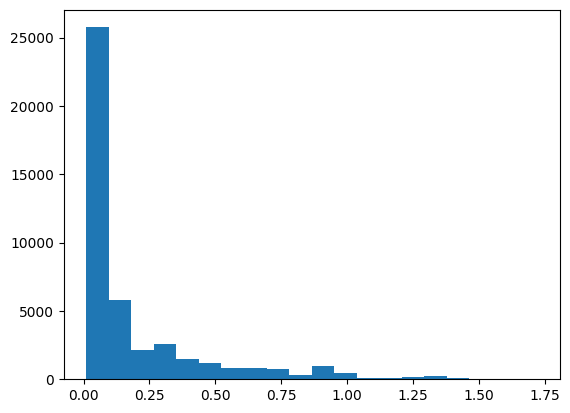

In [ ]:
# Find and show statistics of the dataset
all_data = [x[0] for x in dataset]
all_data = torch.stack(all_data)
mean_value = all_data.mean()
std_value = all_data.std()
max_value = all_data.max()
min_value = all_data.min()

print('\nMax. pixel value: ', max_value)
print('Min. pixel value: ', min_value)

print(f'\nMean pixel value normalized: {mean_value:0.3f}')
print(f'Standard deviation of the normalized pixel values: {std_value:0.3f}')

# Plot the histogram
data_flat = all_data.flatten().cpu().numpy()
plt.hist(data_flat[data_flat >0.01], bins=20)

# Transformations
transforms = Compose([#RandomRotation(10),
                      #RandAugment(),
                      #ToTensor(),
                      Normalize(mean_value, std_value)
                      ])


# Create dataset again, now normalizing the data
dataset = DoseActivityDataset(input_dir=input_dir, output_dir=output_dir, transform=transforms)

# Split dataset into 60% training, 20% validation, 20% testing
train_size = int(0.6 * len(dataset))
test_size = int(0.2 * len(dataset))
val_size = len(dataset) - train_size - test_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# Create DataLoaders for training
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

for batch in train_loader:
    data, labels = batch
    print(f"Batch shape: \nInput shape: {data.shape}, Output shape: {labels.shape}")
    break

Batch shape: 
Input shape: torch.Size([3, 150, 60, 70]), Output shape: torch.Size([3, 150, 60, 70])


In [ ]:
# Use the function
# plot_examples(train_loader)

In [ ]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()

        # Input shape: [batch_size, 1, 70, 60, 150]
        self.conv1 = nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(8, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(64, 8, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv3d(8, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        return x.squeeze(1)

# Create the model
model = BasicCNN().to(device)


In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.activation = nn.Mish()  # Activation function
        self.pool = nn.MaxPool3d(2, stride=2)  # Pooling

        # Encoder layers

        self.e11 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.e12 = nn.Conv3d(16, 16, kernel_size=3, padding=1)

        self.e21 = nn.Conv3d(16, 64, kernel_size=3, padding=1)
        self.e22 = nn.Conv3d(64, 64, kernel_size=3, padding=1)

        # Middle layers

        self.m1 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.m2 = nn.Conv3d(128, 128, kernel_size=3, padding=1)

        # Decoder layers

        self.upconv1 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2, output_padding=(1, 0, 1))  # Upscaling
        self.d11 = nn.Conv3d(128, 64, kernel_size=3, padding=1)
        self.d12 = nn.Conv3d(64, 64, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose3d(64, 48, kernel_size=2, stride=2)  # Upscaling
        self.d21 = nn.Conv3d(64, 16, kernel_size=3, padding=1)
        self.d22 = nn.Conv3d(16, 16, kernel_size=3, padding=1)

        self.output = nn.Conv3d(16, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = x.unsqueeze(1)

        x_e11 = self.activation(self.e11(x))
        x_e12 = self.activation(self.e12(x_e11))
        x_pool1 = self.pool(x_e12)

        x_e21 = self.activation(self.e12(x_pool1))
        x_e22 = self.activation(self.e21(x_e21))
        x_pool2 = self.pool(x_e22)

        x_m1 = self.activation(self.m1(x_pool2))
        x_m2 = self.activation(self.m2(x_m1))

        x_upconv1 = self.upconv1(x_m2)
        x_upconv1 = torch.cat([x_upconv1, x_e22], dim=1)  # Concatenating
        x_d11 = self.activation(self.d11(x_upconv1))
        x_d12 = self.activation(self.d12(x_d11))

        x_upconv2 = self.upconv2(x_d12)
        x_upconv2 = torch.cat([x_upconv2, x_e12], dim=1)  # Concatenating
        x_d21 = self.activation(self.d21(x_upconv2))
        x_d22 = self.activation(self.d22(x_d21))

        x_out = self.output(x_d22)

        return x_out.squeeze(1)


# Create the model
model = UNet().to(device)


In [ ]:
def dice_loss(output, target, smooth=1e-3):
    # Compute the intersection and the sum of the two sets along specified dimensions
    intersection = (target * output).sum(dim=(1, 2, 3))
    total_sum = target.sum(dim=(1, 2, 3)) + output.sum(dim=(1, 2, 3))

    # Compute Dice coefficient
    dice_coeff = (2. * intersection + smooth) / (total_sum + smooth)

    # Compute and return Dice loss averaged over the batch
    return 1. - dice_coeff.mean()

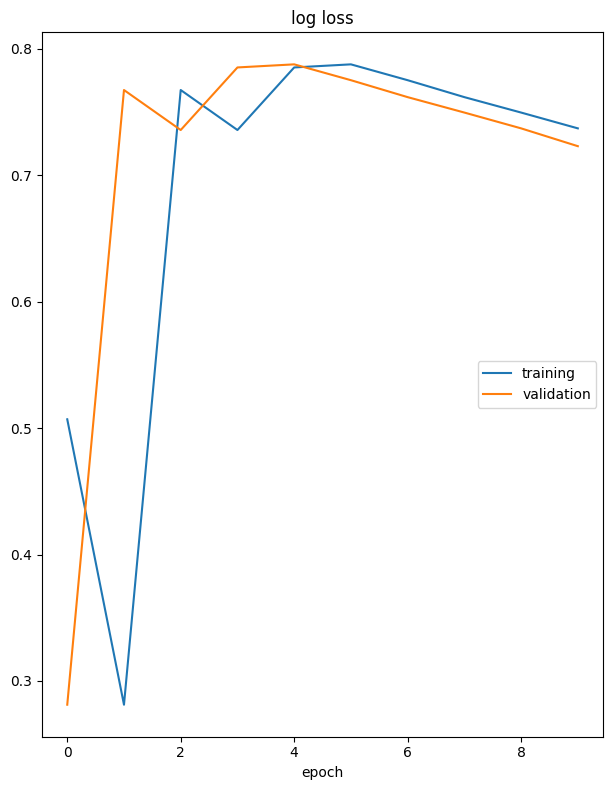

log loss
	training         	 (min:    0.281, max:    0.788, cur:    0.737)
	validation       	 (min:    0.281, max:    0.788, cur:    0.723)


In [ ]:
def train(model, train_loader, val_loader, epochs=10):
    # Initializing the optimizer for the model parameters
    optim = torch.optim.Adam(model.parameters())
    liveloss = PlotLosses()  # Object to track validation and training losses across epochs
    alpha = 0.5  # parameter to weigh the L1 and dice losses
    l1_loss = torch.nn.L1Loss()

    for epoch in range(epochs):
        logs = {}
        train_loss = 0.0
        val_loss = 0.0

        # Training loop
        for batch_input, batch_target in tqdm(train_loader):
            batch_input = batch_input.to(device)
            optim.zero_grad()  # resetting gradients
            batch_output = model(batch_input)  # generating images
            loss = alpha * dice_loss(batch_output, batch_target) + (1 - alpha) * l1_loss(batch_output, batch_target)
            loss.backward()  # backprop
            optim.step()
            train_loss += loss.item()

        # Validation loop
        with torch.no_grad():
            for batch_input, batch_target in tqdm(train_loader):
                batch_input = batch_input.to(device)
                batch_output = model(batch_input)
                loss = alpha * dice_loss(batch_output, batch_target) + (1 - alpha) * l1_loss(batch_output, batch_target)
                val_loss += loss.item()

        # Calculate average losses (to make it independent of batch size)
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        # Log the losses for plotting
        logs['loss'] = avg_train_loss
        logs['val loss'] = avg_val_loss

        liveloss.update(logs)
        liveloss.send()
    return model

trained_model = train(model, train_loader, val_loader)

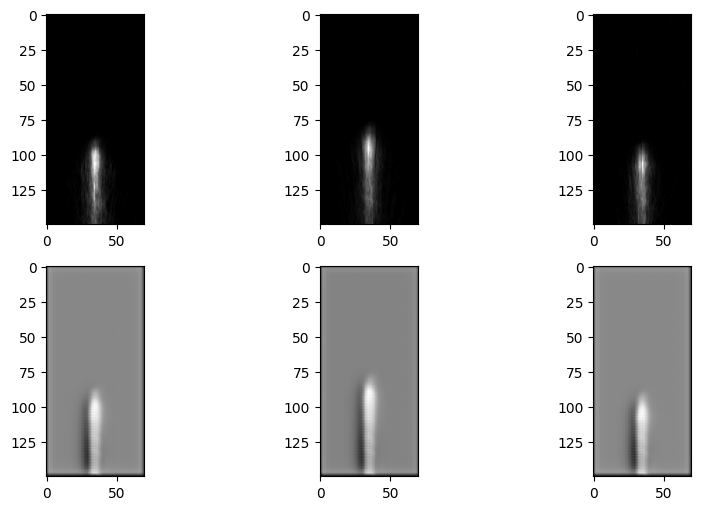

In [ ]:
# Plotting a few examples
input, target = next(iter(train_loader))
trained_model_eval = trained_model.eval()  # Putting the model in training mode
fig, axs = plt.subplots(2, 3, figsize=[10, 6])
for n, idx in enumerate(torch.randint(0,input.shape[0], (3,))):
    output = trained_model_eval(input[idx].unsqueeze(0))
    axs[0, n].imshow(input[idx].squeeze()[:,30,:], cmap='gray')
    axs[1, n].imshow(output.cpu().detach().squeeze()[:,30,:], cmap='gray')
